This project implements a very simple strategy for the selection of stocks from the NASDAQ 100 based on Twitter data. We decided to compute a very simple engagement ratio from Twitter engagement data found online. From this ratio, we shortlist 5 best performing stocks each month and build an equally-weighted portfolio of them. The comparisons ran at the end of this demonstration show that even a strategy this simple can deliver performance.

Although this strategy is of course not to be traded on, working on this project is interesting to better understand how non-financial data can help deliver performant quantitative trading strategies.

In [47]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os 

plt.style.use("ggplot")

### 1. Load Twitter sentiment data
Note: we base this project on an existing CSV file of twitter data related to NASDAQ 100 stocks. In practice, however, this strategy would only work if connected directly to an API. The strategy in itself is, however, what we want to focus on here. 

In [5]:
data_path = "./sentiment_data.csv"
sentiment_df = pd.read_csv(data_path)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date','symbol'])

# We are interested in metrics of engagement to point out and mitigate the effect of bots.
# To this end will calculate the engagement ratio (comments/likes). 
sentiment_df["engagement_ratio"] = sentiment_df["twitterComments"]/sentiment_df["twitterLikes"]

# In order to remove noise, we fix threshold in the number of likes and comments for our investment universe.
sentiment_df = sentiment_df[(sentiment_df["twitterLikes"]>20)&(sentiment_df["twitterComments"]>10)]

### 2. Aggregating monthly and calculating average sentiment for the month

In [12]:
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq="M"),'symbol'])
 [["engagement_ratio"]].mean())

aggregated_df['rank'] = (aggregated_df.groupby(level=0)["engagement_ratio"]
                         .transform(lambda x: x.rank(ascending=False)))
aggregated_df

/var/folders/46/d4fn4d21655bpjrh668pfxs80000gn/T/ipykernel_98495/2470790623.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq="M"),'symbol'])


engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

### 3. Select top 5 stocks based on cross-sectional ranking for each month

In [16]:
filtered_df = aggregated_df[aggregated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date','symbol'])
filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

### 4. Extract the stocks to form a portfolio at the beginning of each month

In [18]:
dates= filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime("%Y-%m-%d")] = filtered_df.xs(d,level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

### 5. Download fresh stock prices for only selected stocks

In [19]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers = stocks_list, start='2021-01-01',end='2023-03-01')


[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


### 6. Calculate portfolio returns with monthly rebalancing

In [28]:
returns_df = np.log(prices_df["Adj Close"]).diff()

portfolio_df = pd.DataFrame()

# As of now, we simply consider an equally-weighted portfolio.
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")

    stocks_of_the_month = fixed_dates[start_date]
    temp_df = returns_df[start_date:end_date][stocks_of_the_month].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df,temp_df],axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


### 7. Download NASDAQ/QQQ prices and compare with our strategy

In [38]:
qqq_df = yf.download(tickers='QQQ',start='2021-01-01',end='2023-03-01')
qqq_ret = np.log(qqq_df["Adj Close"]).diff().to_frame('nasdaq_return')


portfolio_df = portfolio_df.merge(qqq_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


Text(0, 0.5, 'Return')

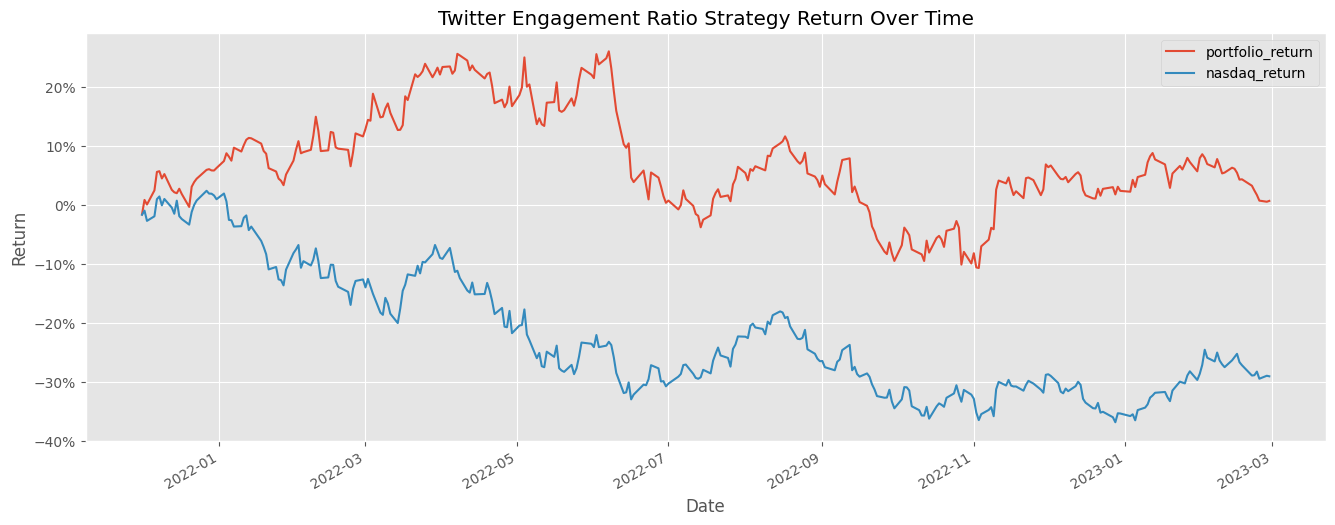

In [48]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)
portfolios_cumulative_return.plot(figsize=(16,6))
plt.title("Twitter Engagement Ratio Strategy Return Over Time")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')